## RNN model using SMILES to Predict S1 & T1 Energies

The dataset has been pre-processed by Kim et al. and was taken from [this paper](https://doi.org/10.1002/bkcs.12516) (DOI: 10.1002/bkcs.12516).  

The pre-processed data in `TADF_data_DL.txt` has the following format:

    ID | SMILES | HOMO | LUMO | E(S1) | E(T1)

This notebook aims to build a simple RNN model using SMILES as input to predict S1 and T1 energies.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd

import random

To ensure that the results obtained are reproducible the random seeds for Python, Numpy and PyTorch are defined.

In [3]:
SEED = 23

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

The dataset is imported and only the S1 & T1

The `get_c_to_i` function returns a dictionary with all of the unique SMILES characters indexed. The dataset contains sequences of varying length which is not ideal for an RNN where batch training is employed. Each sequence is therefore padding with an appropriate number of X characters to ensure an equal length.

In [5]:
#Character to Index mapping

# Data Loading
loaded_data = pd.read_csv("./data/TADF_data_DL.txt", sep ="\t", header=None)
all_data = loaded_data


#Manipulate data using Pandas & RDkit
all_data.columns = ["ID", "SMILES","LUMO", "HOMO", "E(S1)", "E(T1)"]
filt_data = all_data.drop(columns = ["ID", "LUMO", "HOMO"])
filt_data["MOL"] = filt_data["SMILES"].apply(lambda x: Chem.MolFromSmiles(x)) #Add column of Molecular objects
filt_data["CANONICAL SMILES"] = filt_data["MOL"].apply(lambda x: Chem.MolToSmiles(x, canonical = True)) #Add column of Canonical Smiles

filt_data

,SMILES,E(S1),E(T1),MOL,CANONICAL SMILES
0,COC1=CC=CC(=C1)CNC(=O)CSC2=NC3=CC=CC=C3N2C4=CC...,4.3709,3.4974,<rdkit.Chem.rdchem.Mol object at 0x00000218A2A...,COc1cccc(CNC(=O)CSc2nc3ccccc3n2-c2ccccc2)c1
1,CCC1=CC=C(C=C1)N2C(=O)CC(C2=O)N(CC3=CC=C(C=C3)...,3.3935,3.1322,<rdkit.Chem.rdchem.Mol object at 0x00000218A2A...,CCc1ccc(N2C(=O)CC(N(Cc3ccc(OC)cc3)C(=O)/C=C/C(...
2,COC1=C(C=C2C(=C1)N=CN=C2N3C(=NC(=N3)C4=CC=CC=N...,3.3161,2.8620,<rdkit.Chem.rdchem.Mol object at 0x00000218A2A...,COc1cc2ncnc(-n3nc(-c4ccccn4)nc3N)c2cc1OCc1ccccc1
3,CC1=C(C=C(C=C1)SC2=C3C=CN=CC3=C(C4=CC=CC=C42)C...,2.8377,1.7091,<rdkit.Chem.rdchem.Mol object at 0x00000218A2A...,Cc1ccc(Sc2c3ccccc3c(-c3ccc4ccccc4c3)c3cnccc23)...
4,C1OC2=C(O1)C=C(C=C2)N=NC3=C(N4C5=CC=CC=C5N=C4S3)O,2.5995,1.6852,<rdkit.Chem.rdchem.Mol object at 0x00000218A2A...,Oc1c(N=Nc2ccc3c(c2)OCO3)sc2nc3ccccc3n12
...,...,...,...,...,...
42003,CCCN1C2=C(N=C1C3=CN(N=C3)CC#CC4=CC=C(C=C4)C)N(...,3.0977,2.1784,<rdkit.Chem.rdchem.Mol object at 0x00000218A16...,CCCn1c(-c2cnn(CC#Cc3ccc(C)cc3)c2)nc2c1C=NCN2CC
42004,CC1=C(C=C(C=C1)C(=O)NC2CC2)NCCCOC3=CC=C(C=C3)C#N,4.2423,3.2670,<rdkit.Chem.rdchem.Mol object at 0x00000218A16...,Cc1ccc(C(=O)NC2CC2)cc1NCCCOc1ccc(C#N)cc1
42005,COC1=C(C=C(C=C1)C(=O)NCCCNC(=O)C2=NC3=CC=CC=C3...,3.6209,2.9443,<rdkit.Chem.rdchem.Mol object at 0x00000218A16...,COc1ccc(C(=O)NCCCNC(=O)c2nc3ccccc3c(=O)[nH]2)c...
42006,C1CC1NC(=O)C2=C(SN=C2N)NC3CCSC3,4.5018,3.4017,<rdkit.Chem.rdchem.Mol object at 0x00000218A16...,Nc1nsc(NC2CCSC2)c1C(=O)NC1CC1


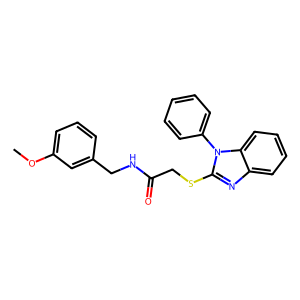

In [9]:
from rdkit.Chem import Draw

t1 = filt_data.iloc[0,-1]

img = Draw.MolToImage(Chem.MolFromSmiles(t1))
img

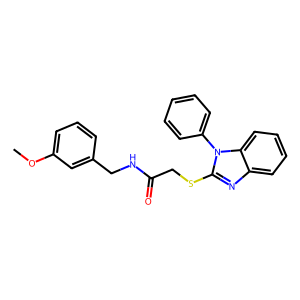

In [12]:
t2 = filt_data.iloc[0,0]
img = Draw.MolToImage(Chem.MolFromSmiles(t2))
img

In [67]:
#Function from paper (not great)

def get_c_to_i(smiles_list):
    c_to_i = {}

    for smiles in smiles_list:
        for letter in smiles:
            if letter not in c_to_i:
                c_to_i[letter] = len(c_to_i)
    c_to_i['X'] = len(c_to_i)
    return c_to_i

def adjust_smiles(smiles_list,maxlen):
    for i in range(len(smiles_list)):
        smiles_list[i] = smiles_list[i].ljust(maxlen,'X')
max_length_index = max(filt_data["SMILES"].str.len().max(), 180)
smiles_list = filt_data["SMILES"].tolist()

c_to_i = get_c_to_i(smiles_list)

adjust_smiles(smiles_list, 100)

c_to_i

def encode_smiles(inp):
    smiles_list = inp
    seq_list = []
    for smiles in smiles_list:
        seq=[]
        for s in smiles:
            seq.append(c_to_i[s])
        seq = torch.from_numpy(np.array(seq))
        seq_list.append(seq)
    return seq_list

seq_list = encode_smiles(smiles_list)
seq_list[0]

tensor([ 0,  1,  0,  2,  3,  0,  0,  3,  0,  0,  4,  3,  0,  2,  5,  0,  6,  0,
         4,  3,  1,  5,  0,  7,  0,  8,  3,  6,  0,  9,  3,  0,  0,  3,  0,  0,
         3,  0,  9,  6,  8,  0, 10,  3,  0,  0,  3,  0,  0,  3,  0, 10, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25, 25, 25, 25, 25], dtype=torch.int32)

Next, a custom dataset class is created.

In [ ]:
path = "./data/TADF_100.txt" #location of data

class RNNDataset_SMILES(Dataset):

    def __init__(self, fn, length = None):
        # Data Loading
        loaded_data = pd.read_csv(fn, sep ="\t", header=None)
        all_data = loaded_data[:length]
        self.data = all_data #Return all data as dataframe

        #Manipulate data using Pandas & RDkit
        all_data.columns = ["ID", "SMILES","LUMO", "HOMO", "E(S1)", "E(T1)"]
        filt_data = all_data.drop(columns = ["ID", "LUMO", "HOMO"])
        filt_data["MOL"] = filt_data["SMILES"].apply(lambda x: Chem.MolFromSmiles(x)) #Add column of Molecular objects

        def calculate_MFP(molecule):
            fp = AllChem.GetMorganFingerprintAsBitVect(molecule, 3, nBits=1024)
            nf = fp.ToList()
            return nf
        
        filt_data["MFP"] = filt_data["MOL"].apply(calculate_MFP)

        mfps = np.array(filt_data["MFP"].tolist())
        #e_s1 = np.array(filt_data["E(S1)"])
        #e_t1 = np.array(filt_data["E(T1)"])

        energies = np.column_stack((filt_data["E(S1)"], filt_data["E(T1)"]))
        
        self.mfps = mfps #Vector of Morgan fingerprints (X by 1024)
        self.energies = energies # Matrix of S1 & T1 energies(X by 2)
        self.n_samples = filt_data.shape[0] #number of data_points

    def __getitem__(self, index):
        # dataset[0]

        return self.mfps[index], self.energies[index]

        """
        energy_dict = dict()

        energy_dict["FP"] = self.mfps[index]
        energy_dict["Energies"] = self.energies[index]

        return energy_dict
        """

    def __len__(self):
        # Length of Dataset
        return self.n_samples

In [ ]:
full_dataset = MFDataset(path)